In [1]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt
import datetime
import random

%matplotlib inline

In [2]:
df = pd.read_csv('../data/Consumer_Complaints_with_Consumer_Complaint_Narratives.csv')

# Create 'df_text' for text modeling

In [3]:
def create_df_text(df):
    df_text = pd.DataFrame()  # Create empty df to fill
    
    df_text['Consumer complaint narrative'] = df['Consumer complaint narrative']
    
    cust_resp_dict ={'Closed':0,
                 'Untimely response':0,
                 'Closed with explanation':1,
                 'Closed with non-monetary relief':2,
                 'Closed with monetary relief':2}
    
    df_text['Company response to consumer'] = df['Company response to consumer'].apply(lambda x: cust_resp_dict[x])
    
    return df_text

In [4]:
create_df_text(df).head()

,Consumer complaint narrative,Company response to consumer
0,Received Capital One charge card offer XXXX. A...,1
1,I do n't know how they got my cell number. I t...,1
2,I 'm a longtime member of Charter One Bank/RBS...,1
3,"After looking at my credit report, I saw a col...",2
4,I received a call from a XXXX XXXX from XXXX @...,1


# Create 'df_no_text' for non-text analysis

In [5]:
def create_df_no_text(df):
    """
    Take input df and fill all missing/NaN or non-sensical data with something
    that is useful in a model.  Also create labels column 'Company response to consumer', with 3 categories.
    INPUT - dataframe
    OUTPUT - 'df_no_text' dataframe for use in modeling non-text features
    """
    df_no_text = pd.DataFrame()  # Create empty df to fill
    
    df['Product'].fillna('Not Provided', inplace=True)
    df['Sub-product'].fillna('Not Provided', inplace=True)
    df['Sub-issue'].fillna('Not Provided', inplace=True)
    df['Issue'].fillna('Not Provided', inplace=True)
    df['Consumer complaint narrative'].fillna('Not Provided', inplace=True)
    df['Company public response'].fillna('Not Provided', inplace=True)
    df['Company'].fillna('Not Provided', inplace=True)
    df['State'].fillna('Not Provided', inplace=True)
    df['ZIP code'].fillna('Not Provided', inplace=True)
    df['Tags'].fillna('Not Provided', inplace=True)
    df['Consumer consent provided?'].fillna('Not Provided', inplace=True)
    df['Submitted via'].fillna('Not Provided',inplace=True)
    df['Consumer disputed?'].fillna('Not Provided', inplace=True)
    
    column=['Product', 'Sub-product','Issue','Sub-issue', 'Company', 'Tags', 'State']
    for name in column:
        repl={}
        i=0
        for value in df[name].unique():
            repl[value] = i
            i+=1

        df[name] = df[name].apply(lambda x: repl[x])
        df_no_text[name] = df[name].astype('category')
        
    cust_resp_dict ={'Closed':0,
                 'Untimely response':0,
                 'Closed with explanation':1,
                 'Closed with non-monetary relief':2,
                 'Closed with monetary relief':2}
    
    df_no_text['Company response to consumer'] = df['Company response to consumer'].apply(lambda x: cust_resp_dict[x])

    return df_no_text



In [6]:
create_df_no_text(df).head()

,Product,Sub-product,Issue,Sub-issue,Company,Tags,State,Company response to consumer
0,0,0,0,0,0,0,0,1
1,1,1,1,1,1,0,1,1
2,0,0,2,0,2,0,2,1
3,2,0,3,2,3,0,3,2
4,1,2,1,3,4,0,4,1


#  Non-text feature modeling

In [98]:
def prep_non_text_data(df):
    from sklearn.preprocessing import StandardScaler, label_binarize, MaxAbsScaler
#     print df.head()
    y_ = df['Company response to consumer']
    y = label_binarize(y_, classes = [0, 1, 2])
    n_classes=3
#     y = y.sum(axis=1)
    df.pop('Company response to consumer')
    X = df.values

    print X.shape, y.shape
    print y
    return X, y

In [120]:
df_no_text = create_df_no_text(df)
X, y = prep_non_text_data(df_no_text)


(84466, 7) (84466, 3)
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ..., 
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [100]:
X.shape, y.shape

((84466, 7), (84466, 3))

In [101]:
def train_test_split_function(X, y):
    from sklearn.cross_validation import train_test_split
    from sklearn.preprocessing import StandardScaler, label_binarize, MaxAbsScaler

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.5,
                                                        random_state=11)
    
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
#     from sklearn.utils import shuffle
#     X_shuf, Y_shuf = shuffle(X_transformed, Y)
    return X_train, X_test, y_train, y_test
    

In [102]:
df_no_text = create_df_no_text(df)
X, y = prep_non_text_data(df_no_text)
X_train, X_test, y_train, y_test = train_test_split_function(X, y)

(84466, 7) (84466, 3)
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ..., 
 [0 1 0]
 [0 1 0]
 [0 0 1]]


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize, MaxAbsScaler
from sklearn.cross_validation import train_test_split

import sklearn.metrics as skm
from sklearn.metrics import roc_curve, auc

from scipy import interp

from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

### One v Rest Classifier

In [104]:
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, n_jobs=-1, class_weight='auto'))
y_score = clf.fit(X_train, y_train).predict_proba(X_test)

In [105]:
score = clf.score(X_test, y_test)
# accuracy = clf.accuracy()
# Precision_Recall = clf.rec

print score

0.718892808941


In [ ]:
def plot()

In [108]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

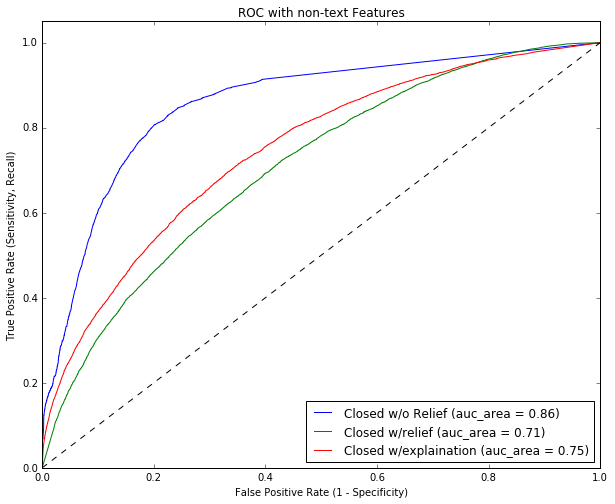

In [110]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief','Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

In [74]:
from sklearn.linear_model import LogisticRegression, SGDClassifier

lr = LogisticRegression(class_weight='auto')
lr.fit(X_train, y_train)

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1

In [181]:
def roc_curve(probabilities, labels):
    '''
    INPUT: numpy array, numpy array
    OUTPUT: list, list, list

    Take a numpy array of the predicted probabilities and a numpy array of the
    true labels.
    Return the True Positive Rates, False Positive Rates and Thresholds for the
    ROC curve.
    '''

    thresholds = np.sort(probabilities)

    tprs = []
    fprs = []

    num_positive_cases = sum(labels)
    num_negative_cases = len(labels) - num_positive_cases

    for threshold in thresholds:
        # With this threshold, give the prediction of each instance
        predicted_positive = probabilities >= threshold
        # Calculate the number of correctly predicted positive cases
        true_positives = np.sum(predicted_positive * labels)
        # Calculate the number of incorrectly predicted positive cases
        false_positives = np.sum(predicted_positive) - true_positives
        # Calculate the True Positive Rate
        tpr = true_positives / float(num_positive_cases)
        # Calculate the False Positive Rate
        fpr = false_positives / float(num_negative_cases)

        fprs.append(fpr)
        tprs.append(tpr)
    
    return tprs, fprs, thresholds.tolist()

def plot_roc(v_probs, y2_test, title, xlabel, ylabel):
    # ROC
    fig = plt.figure(figsize = (8,6))
    tpr, fpr, thresholds = roc_curve(v_probs, y2_test)
    
    import sklearn.metrics as skm
    auc = skm.roc_auc_score(y2_test, v_probs)

    plt.hold(True)
    plt.plot(fpr, tpr)

    # 45 degree line
    xx = np.linspace(0, 1.0, 20)
    plt.plot(xx, xx, 'k--')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    plt.show()
    fig.savefig(title+'.png')

In [182]:
from __future__ import division
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score

%matplotlib inline

In [183]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.cross_validation import train_test_split

In [184]:
def classifier_noFeat(method, df, col):
    y = df[col].values
    X = df.drop(col, axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf = method()
    rf.fit(X_train, y_train)
    print method, 'Accuracy: ', rf.score(X_test, y_test)
    y_score = rf.score(X_test, y_test)

In [185]:
def rf_classifier(method, df, col):
    y = df[col].values
    X = df.drop(col, axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf = method(oob_score=True)
    rf.fit(X_train, y_train)
    print method, 'Accuracy: ', rf.score(X_test, y_test)
    feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                               index=df.columns[:-1])
    y_score = rf.score(X_test, y_test)
    print y_score
    feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
    feat_scores.plot(kind='barh')
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3): #n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    fig = plt.figure(figsize=(10, 8))

    label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
    for i,v in enumerate(label):
        plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity, Recall)')
    plt.title('ROC with non-text Features')
    plt.legend(loc="lower right")


    plt.show()   

In [186]:
def classifier(method, df, col):
    y = df[col].values
    X = df.drop(col, axis=1).values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    rf = method()
    rf.fit(X_train, y_train)
    print method, 'Accuracy: ', rf.score(X_test, y_test)
    y_score = rf.score(X_test, y_test)

    results = rf.predict(X_test)


In [187]:
df_no_text = create_df_no_text(df)

<class 'sklearn.ensemble.forest.RandomForestClassifier'> Accuracy:  0.760102604578
0.760102604578


IndexError: too many indices for array

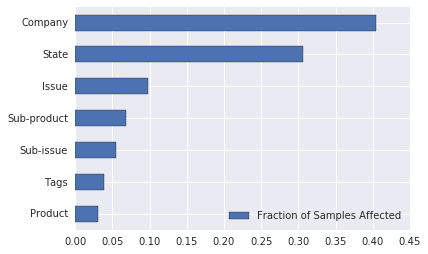

In [188]:
rf_classifier(RandomForestClassifier, df_no_text, 'Company response to consumer')

In [152]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

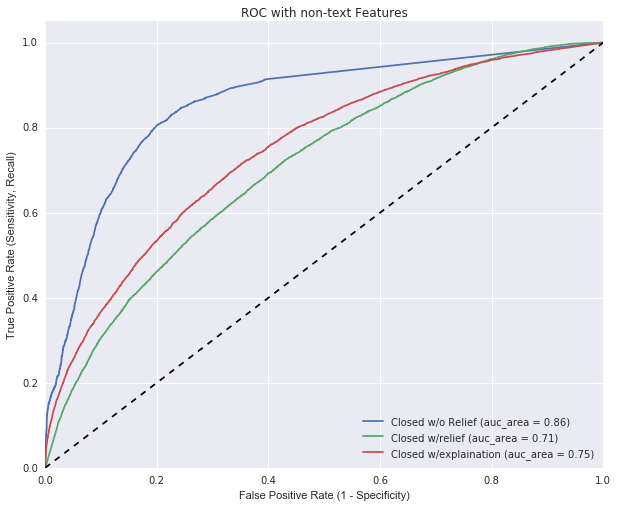

In [153]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

In [154]:
classifier(GradientBoostingClassifier, df_no_text, 'Company response to consumer')

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> Accuracy:  0.790370955012


In [155]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

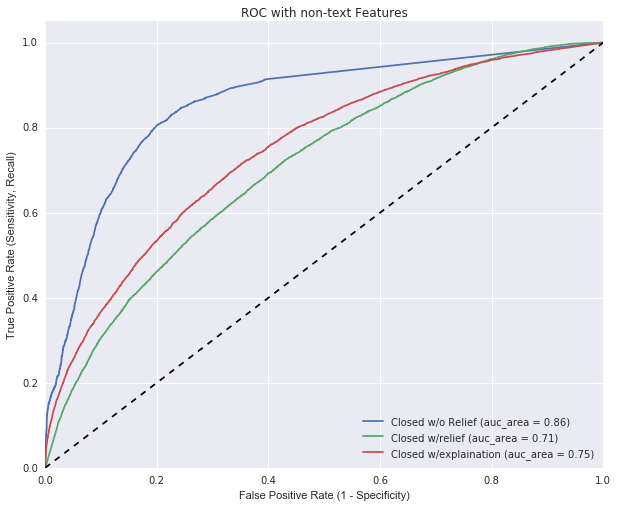

In [156]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

In [157]:
classifier(AdaBoostClassifier, df_no_text, 'Company response to consumer')

<class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'> Accuracy:  0.763812154696


In [158]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

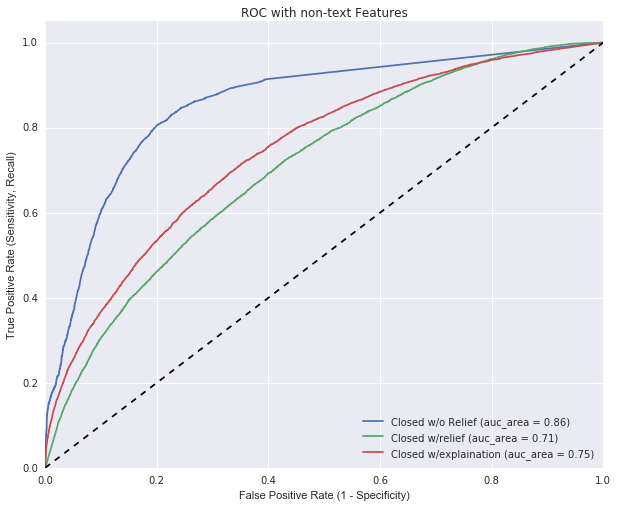

In [159]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

In [164]:
classifier_noFeat(LogisticRegression, df_no_text, 'Company response to consumer')

<class 'sklearn.linear_model.logistic.LogisticRegression'> Accuracy:  0.765074980268


In [165]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

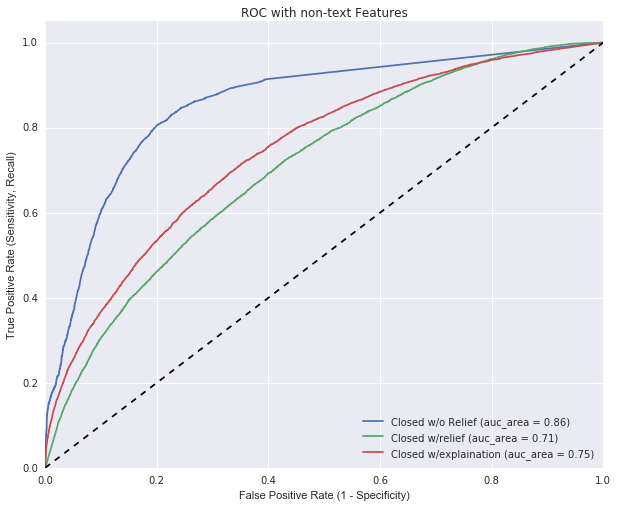

In [166]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

In [167]:
classifier(GradientBoostingClassifier, df_no_text, 'Company response to consumer')

<class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'> Accuracy:  0.786937647987


In [168]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3): #n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i],y_score[:, i],drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

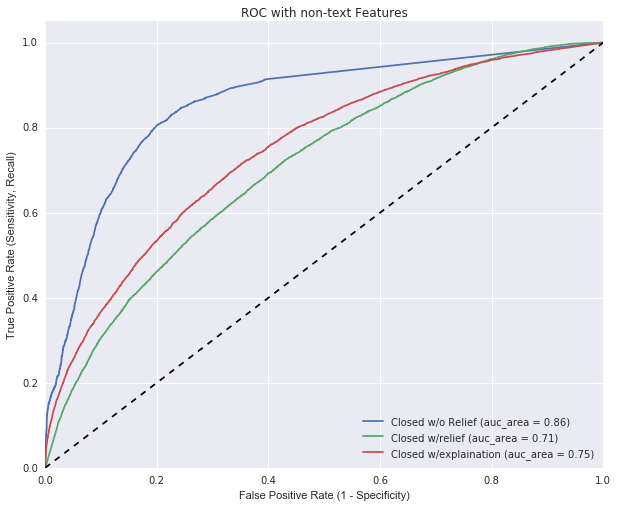

In [169]:
fig = plt.figure(figsize=(10, 8))

label = ['Closed w/o Relief', 'Closed w/relief', 'Closed w/explaination']
for i,v in enumerate(label):
    plt.plot(fpr[i], tpr[i], label= v + ' (auc_area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity, Recall)')
plt.title('ROC with non-text Features')
plt.legend(loc="lower right")


plt.show()

# Using Text Features

In [190]:
def prep_text_data(df):
    from sklearn.preprocessing import StandardScaler, label_binarize, MaxAbsScaler
#     print df.head()
    y_ = df['Company response to consumer']
    y = label_binarize(y_, classes = [0, 1, 2])
    n_classes=3
#     y = y.sum(axis=1)
    df.pop('Company response to consumer')
    X = df.values

    print X.shape, y.shape
    print y
    return X, y

In [191]:
df_text = create_df_text(df)
X, y = prep_text_data(df_text)

(84466, 1) (84466, 3)
[[0 1 0]
 [0 1 0]
 [0 1 0]
 ..., 
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [192]:
def train_test_split_function(X, y):
    from sklearn.cross_validation import train_test_split
    from sklearn.preprocessing import StandardScaler, label_binarize, MaxAbsScaler

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.3,
                                                        random_state=11)
    
#     scaler = StandardScaler()
#     scaler.fit(X_train)
#     X_train = scaler.transform(X_train)
#     X_test = scaler.transform(X_test)
# #     from sklearn.utils import shuffle
#     X_shuf, Y_shuf = shuffle(X_transformed, Y)
    return X_train, X_test, y_train, y_test

In [194]:
X_train, X_test, y_train, y_test = train_test_split_function(X, y)

ValueError: could not convert string to float: PayPal contacted credit bureau without my consent. I want to register a complaint 
